In [1]:
dir_ = r'E:/Data/Antonio/data/manta/DCR/2017-10-16/'
fname = dir_ + '00_DCR.hdf5'
fname

'E:/Data/Antonio/data/manta/DCR/2017-10-16/00_DCR.hdf5'

In [175]:
mlabel = '2017-10-16_00_DCR'
mlabel

'2017-10-16_00_DCR'

# Summary

Compute the optical crosstalk from conincident timestamps according to [Restelli 2006](http://dx.doi.org/10.1080/09500340600790121).

# Load software

In [3]:
from pathlib import Path
from itertools import combinations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif'].insert(0, 'Arial')
plt.rcParams['font.size'] = 14
from tqdm import tnrange, tqdm_notebook

In [4]:
from fretbursts import *

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.
--------------------------------------------------------------
 You are running FRETBursts (version 0.6.5+1.gab87e81).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1371/journal.pone.0160716 

--------------------------------------------------------------


# Define functions

In [5]:
def coincidence_py(timestamps1, timestamps2):
    coinc = 0
    i1, i2 = 0, 0
    while (i1 < timestamps1.size) and (i2 < timestamps2.size):
        if timestamps1[i1] == timestamps2[i2]:
            coinc += 1
            i1 += 1
            i2 += 1
        elif timestamps1[i1] > timestamps2[i2]:
            i2 += 1
        elif timestamps1[i1] < timestamps2[i2]:
            i1 += 1
    return coinc

In [6]:
%load_ext Cython

In [7]:
%%cython
cimport numpy as np

def coincidence(np.int64_t[:] timestamps1, np.int64_t[:] timestamps2):
    cdef np.int64_t coinc, i1, i2, size1, size2
    size1 = timestamps1.size
    size2 = timestamps2.size
    coinc = 0
    i1, i2 = 0, 0
    while i1 < size1 and i2 < size2:
        if timestamps1[i1] == timestamps2[i2]:
            coinc += 1
            i1 += 1
            i2 += 1
        elif timestamps1[i1] > timestamps2[i2]:
            i2 += 1
        elif timestamps1[i1] < timestamps2[i2]:
            i1 += 1
    return coinc

In [8]:
def crosstalk_probability(t1, t2, tol=1e-6, max_iter=100):
    """Estimate crosstalk probability between two pixels in a SPAD array.
    
    Given two input arrays of timestamps `t1` and `t2`, estimate 
    the crosstalk probability using Poisson statistics without 
    approximations.
    
    Arguments:
        t1, t2 (array of ints): arrays of timestamps from DCR measurements
            for the two pixels to be measured. Timestamps need to be 
            integers and coincidences are detected when values in the two 
            arrays are equal. These arrays need to be rescaled, if 
            coincidence need to be computed on a delta t larger than \
            a single timestamp unit.
        tol (float): tollerance for iterative equasion solution
        max_iter (int): max iterations used to solve the equation
        
    Returns:
        A 3-element tuple:
        - crosstalk probability
        - crosstalk probability standard deviation
        - number of iterations used for the estimation.
    """
    T = (max((t1.max(), t2.max())) - min((t1.min(), t2.min())))
    C = coincidence(t1, t2)
    
    # Find C_c by solving eq. (1) iteratively
    C_c, C_u_prev = 0, 0
    for i in range(max_iter):
        C_u = ((1 - np.exp(-(t1.size - C_c)/T)) * 
               (1 - np.exp(-(t2.size - C_c)/T)) * T)
        C_c = C - C_u
        if np.abs(C_u - C_u_prev) < tol:
            break
        C_u_prev = C_u
    
    P_c = C_c / (t1.size + t2.size - C_c)
    if C_c <= 0:
        sigma = np.nan
    else:
        sigma = np.sqrt(C_c) / (t1.size + t2.size - C_c)
    return P_c, sigma, i

def crosstalk(dx, spot1, spot2, divide=1, det=0):
    """
    Calculate the crosstalk between two pixels in a SPAD array for data object, dx. 
    
    Arguments:
        spot1, spot2 (ints): pixel pair for
            combinations possible in 48 spots. The pixel pair 
            tuple needs to be intergers. The optical crosstalk 
            across pixels is computed for a pair of pixels. 
        divide (int): integer division of timestamps by `divide` are the
            timestamps used for coincidence counting.
            `divide` rescales the timestamps so that adjacent timestamps
            become the same timestamp after division.
        det (int): 0, 1 for D, A SPADs respectively. 
        
    Returns:
        A 3-element tuple:
        - A float corresponding to optical crosstalk between the
          selected pixels in the D/A SPAD array.
        - A float corresponding to the standard deviation of optical crosstalk
          between the selected pixels in the D/A SPAD array.
        - A float indicating the probability of optical crosstalk between
          selected pixels.
    """
    ph1 = dx.ph_times_m[spot1][dx.detectors[spot1] == det] // divide
    ph2 = dx.ph_times_m[spot2][dx.detectors[spot2] == det] // divide
    delta_t = d.clk_p*divide
    if ph1.size == 0 or ph2.size == 0:
        return np.nan, np.nan, 0
    ct, sigma, i = crosstalk_probability(ph1, ph2)
    return ct, sigma, i

In [9]:
def dist(manta_shape, ich1, ich2):
    """Compute distance between two pixels on the SPAD array.
    """
    row1, col1 = np.where(manta_shape == ich1)
    row2, col2 = np.where(manta_shape == ich2)
    del_x = abs(col2 - col1) 
    del_y = abs(row2 - row1)
    dist = float(np.sqrt((del_x)**2 + (del_y)**2)) #multipy by 500 to convert to microns
    return(dist)

In [180]:
def savefig(fname, **kwargs):
    """Save figure with default arguments."""
    import os
    basename = os.path.basename(fname)
    dir_ = f'figures/{mlabel}_'
    kwargs_ = dict(dpi=180, bbox_inches='tight', 
                   frameon=True, facecolor='white', transparent=False)
    kwargs_.update(kwargs)
    plt.savefig(dir_ + basename, **kwargs_)
    print('Saved: ', dir_ + basename)

# Computer distances for a pair of pixels for all combinations of 48 spots

In [11]:
d = loader.photon_hdf5(fname)

## Example DCR timetrace for spot 31 of D-SPAD

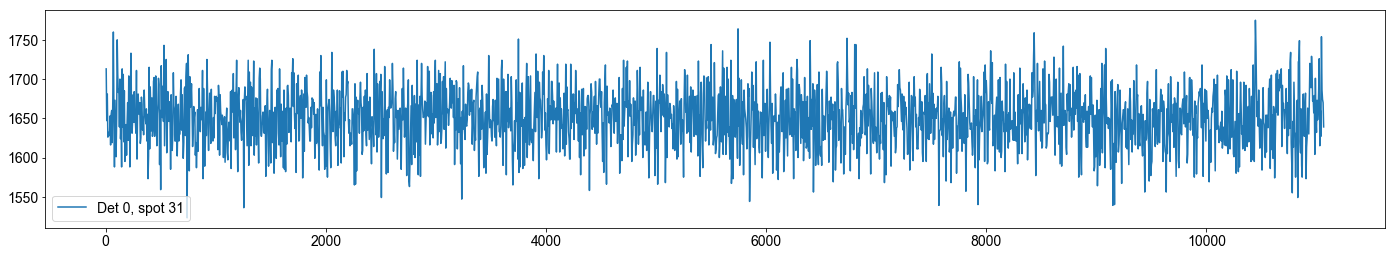

In [12]:
spot = 31
det = 0
ph = d.ph_times_m[spot][d.detectors[spot] == det] * d.clk_p
counts, bins = np.histogram(ph, bins=np.arange(0, d.time_max, 5))

fig, ax = plt.subplots(figsize=(24, 4))
ax.plot(bins[1:], counts, label='Det %d, spot %d' % (det, spot))
plt.legend()
display(fig)
plt.close(fig)

In [13]:
d.detectors[0].shape

(6846745,)

In [14]:
d.ph_times_m[0].shape

(6846745,)

In [15]:
manta_shape = np.arange(48).reshape(4, 12)[::-1].T[::-1]
manta_shape

array([[47, 35, 23, 11],
       [46, 34, 22, 10],
       [45, 33, 21,  9],
       [44, 32, 20,  8],
       [43, 31, 19,  7],
       [42, 30, 18,  6],
       [41, 29, 17,  5],
       [40, 28, 16,  4],
       [39, 27, 15,  3],
       [38, 26, 14,  2],
       [37, 25, 13,  1],
       [36, 24, 12,  0]])

# Compute crosstalk

> **NOTE**: The iterator `combinations(range(48), 2)` generates all the combinations of 48 pixel IDs.

We start by computing all paris of pixels (`pix_pairs`) and all the distances for all the pairs of pixels (`distances`):

In [16]:
pix_pairs = []
distances = []
for ich1, ich2 in combinations(range(48), 2):
    pix_pairs.append((ich1, ich2))
    distances.append(dist(manta_shape, ich1, ich2))

Then we compute the crosstalk for all pairs of pixes on both arrays.
Results are stored in a table (pandas.DataFrame).

In [19]:
def compute_crosstalk_detector(det):
    xtalk_err_list = []
    for ich1, ich2 in tqdm_notebook(combinations(range(48), 2), total=len(distances), desc=f'Det. {det}', leave=True):
        res = crosstalk(d, ich1, ich2, divide=4, det=det)
        xtalk_err_list.append(res)
        if res[2] > 50:
            print('i', ich1, ich2, flush=True)
        if np.isnan(res[1]):
            print(f'  W: Crosstalk for detector {det} pair {ich1}, {ich2} is NaN.', flush=True)

    xtalk_err_array = np.array(xtalk_err_list)
    pairdata =  pd.DataFrame(columns=['crosstalk', 'distance', 'error'])
    pairdata['crosstalk'] = xtalk_err_array[:, 0]        
    pairdata['error'] = xtalk_err_array[:, 1]
    pairdata['distance'] = distances
    pairdata['pix1'] = np.array(pix_pairs)[:,0]
    pairdata['pix2'] = np.array(pix_pairs)[:,1]
    return pairdata

def compute_crosstalk_both_dectectors(recompute=False):
    res = []
    for det in (0, 1):
        fname_crosstalk = f'results/{mlabel}_crosstalk_data_detector{det}.csv'
        if Path(fname_crosstalk).exists():
            print(f'- Loading crosstalk for detector {det} from cache', flush=True)
            pairdata = pd.read_csv(fname_crosstalk, index_col=0)
        else:
            print(f'- Computing crosstalk for detector {det}', flush=True)
            pairdata = compute_crosstalk_detector(det)  
            pairdata.to_csv(fname_crosstalk)
        res.append(pairdata)
    return res

In [20]:
pairdata0, pairdata1 = compute_crosstalk_both_dectectors(recompute=False)
pairdata = pairdata1

- Computing crosstalk for detector 0


238/|/ 21%|| 238/1128 [01:10<04:22,  3.40it/s]                                                                         
  W: Crosstalk for detector 0 pair 0, 12 is NaN.
  W: Crosstalk for detector 0 pair 0, 13 is NaN.
  W: Crosstalk for detector 0 pair 1, 12 is NaN.
  W: Crosstalk for detector 0 pair 1, 13 is NaN.
  W: Crosstalk for detector 0 pair 2, 12 is NaN.
  W: Crosstalk for detector 0 pair 2, 13 is NaN.
  W: Crosstalk for detector 0 pair 3, 12 is NaN.
  W: Crosstalk for detector 0 pair 3, 13 is NaN.
  W: Crosstalk for detector 0 pair 4, 12 is NaN.
  W: Crosstalk for detector 0 pair 4, 13 is NaN.
  W: Crosstalk for detector 0 pair 5, 12 is NaN.
  W: Crosstalk for detector 0 pair 5, 13 is NaN.
  W: Crosstalk for detector 0 pair 6, 12 is NaN.
  W: Crosstalk for detector 0 pair 6, 13 is NaN.
  W: Crosstalk for detector 0 pair 7, 12 is NaN.
  W: Crosstalk for detector 0 pair 7, 13 is NaN.
  W: Crosstalk for detector 0 pair 8, 12 is NaN.
  W: Crosstalk for detector 0 pair 8, 13 is NaN

  W: Crosstalk for detector 1 pair 0, 6 is NaN.
  W: Crosstalk for detector 1 pair 13, 35 is NaN.
  W: Crosstalk for detector 1 pair 36, 45 is NaN.



In [21]:
pairdata.head()

,crosstalk,distance,error,pix1,pix2
0,0.000772,1.0,1.481646e-05,0,1
1,0.000014,2.0,2.193197e-06,0,2
2,0.000007,3.0,2.729624e-06,0,3
3,0.000002,4.0,8.092910e-07,0,4
4,0.000010,5.0,3.699850e-06,0,5


# Plots

Text(0.5,1,'Crosstalk vs distance')

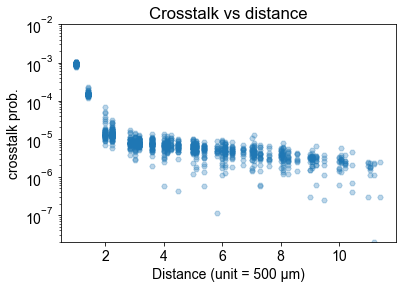

In [22]:
pairdata.plot(x='distance', y='crosstalk', kind='scatter', alpha=0.3, marker='H', s=30,
               logy=True, ylim=(2e-8, 10e-3));
plt.ylabel(u'crosstalk prob.')
plt.xlabel(u'Distance (unit = 500 μm)')
plt.title('Crosstalk vs distance')

Optical crosstalk between pixels is maximal at shorter distances.

In [23]:
pairdata.crosstalk.max()

0.001042788265769392

Optical crosstalk along the x,y axes is determined by selecting a pair of neighboring pixels.

Text(0,0.5,'Probability $\\times \\; 10^{-3}$')

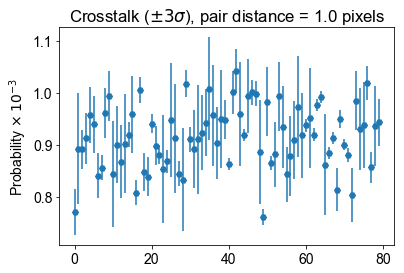

In [24]:
dist = 1
mask = pairdata['distance'] == dist
plt.errorbar(x=np.arange(mask.sum()), y=pairdata['crosstalk'][mask]*1e3, yerr=3*pairdata['error'][mask]*1e3, fmt='H')
plt.title('Crosstalk ($\pm 3\sigma$), pair distance = %.1f pixels' % dist);
plt.ylabel(r'Probability $\times \; 10^{-3}$')

Optical crosstalk along the diagonal is determined by selecting a pair of cater-cornered pixels and calculating the distance along the diagonal with the Pythagorian Theorem.

Text(0,0.5,'Probability $\\times \\; 10^{-3}$')

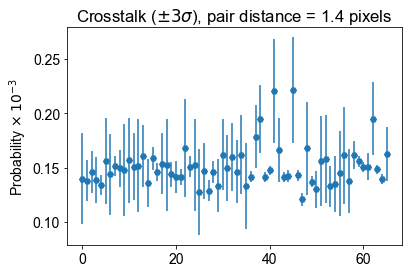

In [25]:
dist = np.sqrt(2)
mask = pairdata['distance'] == dist
plt.errorbar(x=np.arange(mask.sum()), y=pairdata['crosstalk'][mask]*1e3, yerr=3*pairdata['error'][mask]*1e3, fmt='H')
plt.title('Crosstalk ($\pm 3\sigma$), pair distance = %.1f pixels' % dist);
plt.ylabel(r'Probability $\times \; 10^{-3}$')

Here, optical crosstalk along the x,y axes is calculated for a pair of pixels separated by a distance equal to two pixels.

Text(0,0.5,'Probability $\\times \\; 10^{-3}$')

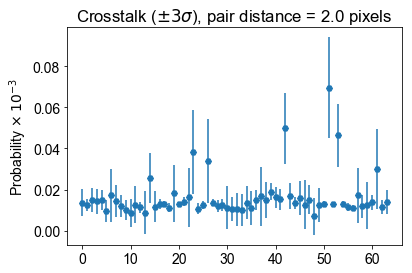

In [26]:
dist = 2
mask = pairdata['distance'] == dist
plt.errorbar(x=np.arange(mask.sum()), y=pairdata['crosstalk'][mask]*1e3, yerr=3*pairdata['error'][mask]*1e3, fmt='H')
plt.title('Crosstalk ($\pm 3\sigma$), pair distance = %.1f pixels' % dist);
plt.ylabel(r'Probability $\times \; 10^{-3}$')

# Crosstalk vs chip position

In [27]:
def pixel_rowcol_to_ch(d, row, col):
    detectors = d.setup['detectors']
    i = np.where((detectors['position'] == (row, col)).sum(axis=1) == 2)[0][0]
    ich = detectors['spot'][i]
    return ich

def pixel_ch_to_rowcol(d, ich):
    detectors = d.setup['detectors']
    ich = np.where(detectors['spot'] == ich)
    pix_pos = detectors['position'][ich][0]
    return pix_pos

In [28]:
detectors = d.setup['detectors']

In [29]:
nshape = len(manta_shape[0,:])*2 - 1, len(manta_shape[:,1])*2 - 1
nshape

(7, 23)

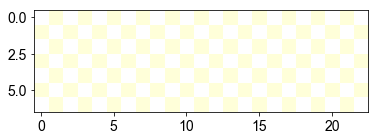

In [30]:
a = np.zeros(nshape)
a[1::2, 1::2] = np.nan
a[0::2, 0::2] = np.nan
plt.imshow(a, interpolation='none', cmap='YlGnBu')
plt.grid(False)

### Opitcal crosstalk calculated for pixels of distance  $d=1$ 

In [31]:
dist = 1

mask = pairdata['distance'] == dist
pairdata_d1 = pairdata.loc[mask]
pairdata_d1.head()

,crosstalk,distance,error,pix1,pix2
0,0.000772,1.0,0.000015,0,1
11,0.000893,1.0,0.000036,0,12
47,0.000892,1.0,0.000013,1,2
58,0.000913,1.0,0.000016,1,13
93,0.000958,1.0,0.000018,2,3


In [32]:
def pair_coord(pix1, pix2):
    """
    Returns (i, j) position in the expanded `a` array used to generate 
    heatmap of optical crosstalk for a pair of pixels 
    `pix1` and `pix2` (pixel ids, [0, 47]).
    """
    v1 = pixel_ch_to_rowcol(d, pix1)
    v2 = pixel_ch_to_rowcol(d, pix2)
    return (v1[0] + v2[0]), (v1[1] + v2[1])

In [33]:
for p, pair in pairdata_d1.iterrows():
    i, j = pair_coord(pair.pix1, pair.pix2)
    a[j, i] = pair.crosstalk
    print(i, j, pair.pix1, pair.pix2, pair.crosstalk)

21 6 0.0 1.0 0.00077201824504
22 5 0.0 12.0 0.000892731640029
19 6 1.0 2.0 0.00089156042939
20 5 1.0 13.0 0.000912657555786
17 6 2.0 3.0 0.000958052654574
18 5 2.0 14.0 0.000939534904962
15 6 3.0 4.0 0.000841339129603
16 5 3.0 15.0 0.000856448109395
13 6 4.0 5.0 0.000961276564166
14 5 4.0 16.0 0.000994354928477
11 6 5.0 6.0 0.000844633469527
12 5 5.0 17.0 0.000900727950482
9 6 6.0 7.0 0.000868103312585
10 5 6.0 18.0 0.000902215453757
7 6 7.0 8.0 0.000919872195985
8 5 7.0 19.0 0.000958687320392
5 6 8.0 9.0 0.000808817251194
6 5 8.0 20.0 0.00100561735327
3 6 9.0 10.0 0.000848030744309
4 5 9.0 21.0 0.000838831540645
1 6 10.0 11.0 0.000941117387098
2 5 10.0 22.0 0.000898586066725
0 5 11.0 23.0 0.000881744124913
21 4 12.0 13.0 0.000854305867564
22 3 12.0 24.0 0.00086874414514
19 4 13.0 14.0 0.000948000567278
20 3 13.0 25.0 0.00091335731996
17 4 14.0 15.0 0.000845209295247
18 3 14.0 26.0 0.00083385165167
15 4 15.0 16.0 0.00101783201993
16 3 15.0 27.0 0.000910680470317
13 4 16.0 17.0 0.000891

### Opitcal crosstalk calculated for cater-corner pixels of distance $d=2^{1/2}$ 

In [34]:
dist = np.sqrt(2)

mask = pairdata['distance'] == dist
pairdata_diag = pairdata.loc[mask]
pairdata_diag

,crosstalk,distance,error,pix1,pix2
12,0.000140,1.414214,0.000014,0,13
57,0.000138,1.414214,0.000006,1,12
59,0.000146,1.414214,0.000006,1,14
103,0.000139,1.414214,0.000007,2,13
105,0.000134,1.414214,0.000003,2,15
...,...,...,...,...,...
1033,0.000151,1.414214,0.000004,33,44
1035,0.000195,1.414214,0.000011,33,46
1047,0.000148,1.414214,0.000002,34,45
1049,0.000139,1.414214,0.000001,34,47


In [35]:
for p, pair in pairdata_diag.iterrows():
    i = pair_coord(pair.pix1, pair.pix2)[0]
    j = pair_coord(pair.pix1, pair.pix2)[1]
    a[j, i] = pair.crosstalk
    print(i, j, pair.pix1, pair.pix2, pair.crosstalk)

21 5 0.0 13.0 0.000139690015252
21 5 1.0 12.0 0.000137872719142
19 5 1.0 14.0 0.000145791192903
19 5 2.0 13.0 0.000138820424027
17 5 2.0 15.0 0.000133872308645
17 5 3.0 14.0 0.000155861672553
15 5 3.0 16.0 0.000143710303677
15 5 4.0 15.0 0.000151088408146
13 5 4.0 17.0 0.000149290239869
13 5 5.0 16.0 0.000147582049536
11 5 5.0 18.0 0.000156739223569
11 5 6.0 17.0 0.000150882735619
9 5 6.0 19.0 0.000151623264722
9 5 7.0 18.0 0.000160583799972
7 5 7.0 20.0 0.00013597336644
7 5 8.0 19.0 0.000158394809203
5 5 8.0 21.0 0.000146022886052
5 5 9.0 20.0 0.000153680667505
3 5 9.0 22.0 0.000152419173049
3 5 10.0 21.0 0.00014375618143
1 5 10.0 23.0 0.000141454106635
1 5 11.0 22.0 0.0001414570004
21 3 12.0 25.0 0.000168107844643
21 3 13.0 24.0 0.000150935599489
19 3 13.0 26.0 0.000152468438035
19 3 14.0 25.0 0.000127391500221
17 3 14.0 27.0 0.000146906220696
17 3 15.0 26.0 0.000128881424005
15 3 15.0 28.0 0.000146006159789
15 3 16.0 27.0 0.000133420772315
13 3 16.0 29.0 0.000161717841478
13 3 17.0 

In [36]:
m = manta_shape.T[::-1]
m

array([[11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1,  0],
       [23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12],
       [35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24],
       [47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36]])

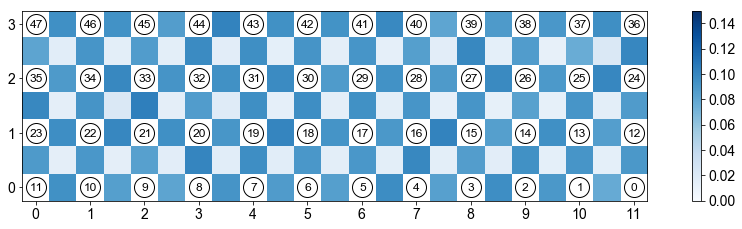

In [37]:
fig, ax = plt.subplots(figsize=(16, 3.5))
xs = np.arange(12)
ys = np.repeat(np.arange(4)[np.newaxis,:].T, xs.size, axis=1)
plt.plot(xs, ys.T, 'o', ms=20, mew=1, mec='k', color='white')
im = plt.imshow(a*1e2, interpolation='none', cmap='Blues', vmin=0, vmax=0.15,
                extent=(-0.25, 11.25, -0.25, 3.25))
for row in range(4):
    for col in range(12):
        ax.text(col+0.01, row-0.01, str(m[row,col]), va='center', ha='center', fontsize=12)
im.cmap.set_under(alpha=0)
plt.colorbar()
plt.xticks(range(12))
plt.yticks(range(4))
plt.grid(False)

# Crosstalk figure

In [94]:
def compute_heatmap(pairdata):
    a = np.zeros(nshape)*np.nan
    dist = 1
    mask = pairdata['distance'] == dist
    pairdata_d1 = pairdata.loc[mask]
    for p, pair in pairdata_d1.iterrows():
        i, j = pair_coord(pair.pix1, pair.pix2)
        a[j, i] = pair.crosstalk
        #print(i, j, pair.pix1, pair.pix2, pair.crosstalk)

    dist = np.sqrt(2)
    mask = pairdata['distance'] == dist
    pairdata_diag = pairdata.loc[mask]
    for p, pair in pairdata_diag.iterrows():
        i, j = pair_coord(pair.pix1, pair.pix2)
        a[j, i] = pair.crosstalk
    #print(i, j, pair.pix1, pair.pix2, pair.crosstalk)
    return a

In [95]:
a0 = compute_heatmap(pairdata0)
a1 = compute_heatmap(pairdata1)

Saved:  figures/2017-10-16_00_DCR_crosstalk_both_detectors


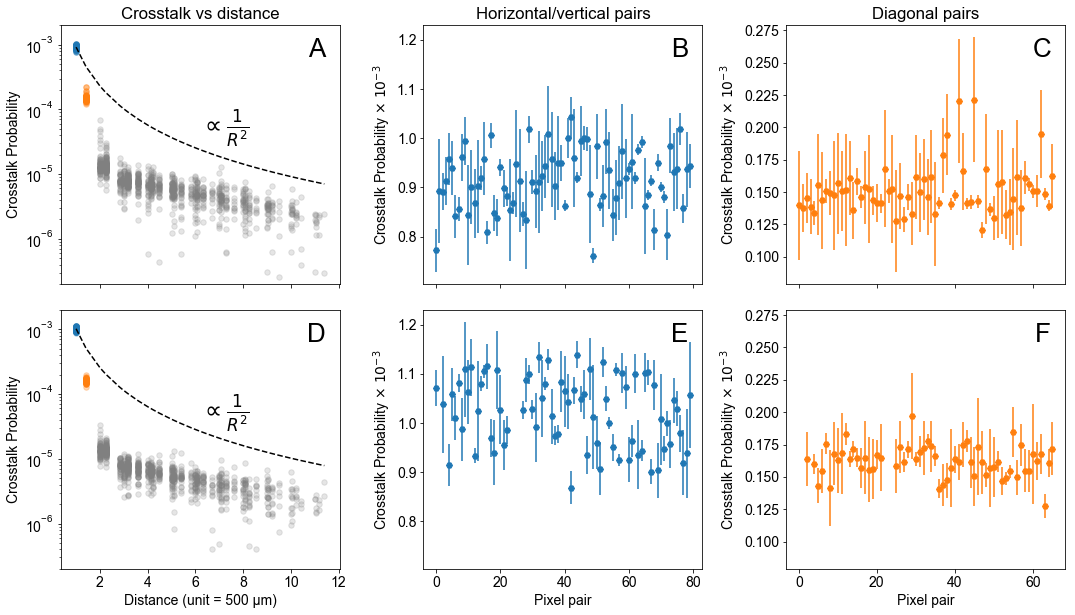

In [182]:
fig, AX = plt.subplots(2, 3, figsize=(18, 10), sharex='col', sharey='col')
ax1a = AX[0, 0]
ax2a = AX[0, 1]
ax3a = AX[0, 2]
ax1d = AX[1, 0]
ax2d = AX[1, 1]
ax3d = AX[1, 2]
plt.subplots_adjust(hspace=0.1, wspace=0.3)

xtext, ytext = 0.95, 0.95
font_kw = dict(fontsize=26, va='top', ha='right')

pairdata = pairdata1
ax1a.scatter('distance', 'crosstalk', data=pairdata.loc[pairdata.distance == 1], alpha=0.3, s=30, c='C0')
ax1a.scatter('distance', 'crosstalk', data=pairdata.loc[pairdata.distance == np.sqrt(2)], alpha=0.3, s=30, c='C1')
ax1a.scatter('distance', 'crosstalk', data=pairdata.loc[pairdata.distance > np.sqrt(2)], alpha=0.2, s=30, c='grey')
ax1a.set_yscale('log')
ax1a.set_ylim(2e-7, 2e-3)
ax1a.set_ylabel(r'Crosstalk Probability')
#ax1a.set_xlabel(u'Distance (unit = 500 μm)')
ax1a.set_title('Crosstalk vs distance')
ax1a.text(xtext, ytext, 'A', transform=ax1a.transAxes, **font_kw)
x = np.unique(pairdata.distance)
A = pairdata.loc[pairdata.distance == 1, 'crosstalk'].mean()
y = A / x**2
ax1a.plot(x, y, ls='--', color='k')
ax1a.text(0.5, 0.58, r'$\propto \frac{1}{R^2}$', transform=ax1a.transAxes, fontsize=24)
# A = pairdata.loc[pairdata.distance == np.sqrt(2), 'crosstalk'].mean() * 2
# y = A / x**2
# ax1a.plot(x, y, ls='--', color='k')
# A = 3e-3
# y = A / reflection_distance(x)**2
# ax1a.plot(x, y, ls='-', color='k')

dist = 1
mask = pairdata['distance'] == dist
ax2a.errorbar(x=np.arange(mask.sum()), y=pairdata['crosstalk'][mask]*1e3, yerr=3*pairdata['error'][mask]*1e3, fmt='H', color='C0')
ax2a.set_title('Horizontal/vertical pairs');
ax2a.set_ylabel(r'Crosstalk Probability $\times \; 10^{-3}$')
#ax2a.set_xlabel('Pixel pair')
ax2a.text(xtext, ytext, 'B', transform=ax2a.transAxes, **font_kw)

dist = np.sqrt(2)
mask = pairdata['distance'] == dist
ax3a.errorbar(x=np.arange(mask.sum()), y=pairdata['crosstalk'][mask]*1e3, yerr=3*pairdata['error'][mask]*1e3, fmt='H', color='C1')
ax3a.set_title('Diagonal pairs');
ax3a.set_ylabel(r'Crosstalk Probability $\times \; 10^{-3}$')
#ax3a.set_xlabel('Pixel pair')
ax3a.text(xtext, ytext, 'C', transform=ax3a.transAxes, **font_kw)

pairdata = pairdata0
ax1d.scatter('distance', 'crosstalk', data=pairdata.loc[pairdata.distance == 1], alpha=0.3, s=30, c='C0')
ax1d.scatter('distance', 'crosstalk', data=pairdata.loc[pairdata.distance == np.sqrt(2)], alpha=0.3, s=30, c='C1')
ax1d.scatter('distance', 'crosstalk', data=pairdata.loc[pairdata.distance > np.sqrt(2)], alpha=0.2, s=30, c='grey')
ax1d.set_yscale('log')
ax1d.set_ylim(2e-7, 2e-3)
ax1d.set_ylabel(r'Crosstalk Probability')
ax1d.set_xlabel(u'Distance (unit = 500 μm)')
#ax1d.set_title('Crosstalk vs distance')
ax1d.text(xtext, ytext, 'D', transform=ax1d.transAxes, **font_kw)
x = np.unique(pairdata.distance)
A = pairdata.loc[pairdata.distance == 1, 'crosstalk'].mean()
y = A / x**2
ax1d.plot(x, y, ls='--', color='k')
ax1d.text(0.5, 0.58, r'$\propto \frac{1}{R^2}$', transform=ax1d.transAxes, fontsize=24)

dist = 1
mask = pairdata['distance'] == dist
ax2d.errorbar(x=np.arange(mask.sum()), y=pairdata['crosstalk'][mask]*1e3, yerr=3*pairdata['error'][mask]*1e3, fmt='H', color='C0')
#ax2d.set_title('Horizontal/vertical pairs');
ax2d.set_ylabel(r'Crosstalk Probability $\times \; 10^{-3}$')
ax2d.set_xlabel('Pixel pair')
ax2d.text(xtext, ytext, 'E', transform=ax2d.transAxes, **font_kw)

dist = np.sqrt(2)
mask = pairdata['distance'] == dist
ax3d.errorbar(x=np.arange(mask.sum()), y=pairdata['crosstalk'][mask]*1e3, yerr=3*pairdata['error'][mask]*1e3, fmt='H', color='C1')
#ax3d.set_title('Diagonal pairs');
ax3d.set_ylabel(r'Crosstalk Probability $\times \; 10^{-3}$')
ax3d.set_xlabel('Pixel pair')
ax3d.text(xtext, ytext, 'F', transform=ax3d.transAxes, **font_kw);
savefig('crosstalk_both_detectors')

$$\frac{A}{R^2} = \langle P_c \rangle$$

$$A = \langle P_c \rangle {R^2}$$


In [155]:
def reflection_distance(dist, thickness=1):
    return np.sqrt((dist/2)**2 + thickness*2)*2

In [184]:
def plot_crosstalk_heatmap(a, ax, title='Spatial distribution of crosstalk', cmap='Blues', vmin=0, vmax=1.5):
    m = manta_shape.T[::-1]
    xs = np.arange(12)
    ys = np.repeat(np.arange(4)[np.newaxis,:].T, xs.size, axis=1)
    ax.plot(xs, ys.T, 'o', ms=20, mew=1, mec='k', color='white')
    im = ax.imshow(a*1e3, interpolation='none',  cmap=cmap, vmin=vmin, vmax=vmax,
                    extent=(-0.25, 11.25, -0.25, 3.25))
    for row in range(4):
        for col in range(12):
            ax.text(col+0.01, row-0.01, str(m[row,col]), va='center', ha='center', fontsize=12)
    ax.set_xticks(range(12))
    ax.set_yticks(range(4));
    ax.set_title(title)
    ax.text(1.14, 0.5, r'Crosstalk Probability $\times \; 10^{-3}$', rotation=90, va='center', transform=ax.transAxes)
    return im

Saved:  figures/2017-10-16_00_DCR_crosstalk_heatmaps_both_detectors


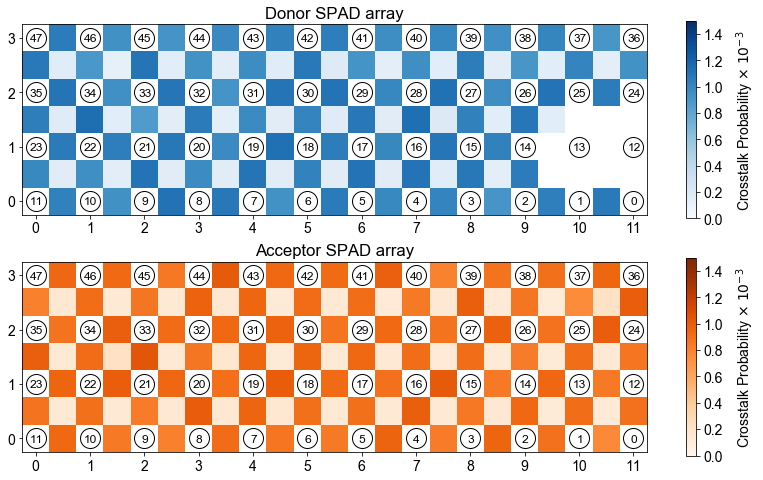

In [185]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(14, 8))
im1 = plot_crosstalk_heatmap(a1, ax1, title='Acceptor SPAD array', cmap='Oranges')
fig.colorbar(im1, ax=ax1)
im0 = plot_crosstalk_heatmap(a0, ax0, title='Donor SPAD array', cmap='Blues')
fig.colorbar(im0, ax=ax0)
savefig('crosstalk_heatmaps_both_detectors')

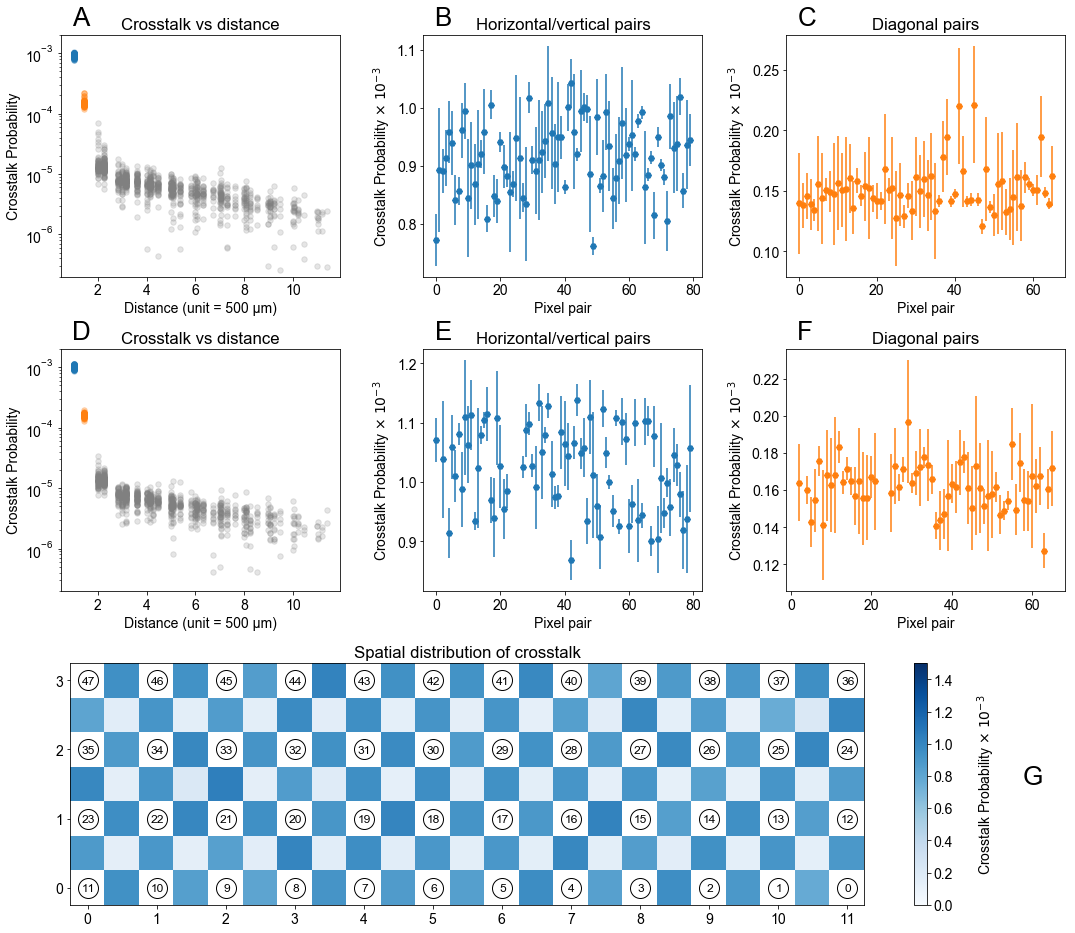

In [97]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(18, 16))
gs = gridspec.GridSpec(3, 3,
                       width_ratios=[1, 1, 1],
                       height_ratios=[1, 1, 1]
                       )
ax1a = plt.subplot(gs[0, 0])
ax2a = plt.subplot(gs[0, 1])
ax3a = plt.subplot(gs[0, 2])
ax1d = plt.subplot(gs[1, 0])
ax2d = plt.subplot(gs[1, 1])
ax3d = plt.subplot(gs[1, 2])
axh = plt.subplot(gs[2, :])
gs.update(hspace=0.3, wspace=0.3)

pairdata = pairdata1
ax1a.scatter('distance', 'crosstalk', data=pairdata.loc[pairdata.distance == 1], alpha=0.3, s=30, c='C0')
ax1a.scatter('distance', 'crosstalk', data=pairdata.loc[pairdata.distance == np.sqrt(2)], alpha=0.3, s=30, c='C1')
ax1a.scatter('distance', 'crosstalk', data=pairdata.loc[pairdata.distance > np.sqrt(2)], alpha=0.2, s=30, c='grey')
ax1a.set_yscale('log')
ax1a.set_ylim(2e-7, 2e-3)
ax1a.set_ylabel(r'Crosstalk Probability')
ax1a.set_xlabel(u'Distance (unit = 500 μm)')
ax1a.set_title('Crosstalk vs distance')
ax1a.text(0.04, 1.04, 'A', fontsize=26, transform=ax1a.transAxes)

dist = 1
mask = pairdata['distance'] == dist
ax2a.errorbar(x=np.arange(mask.sum()), y=pairdata['crosstalk'][mask]*1e3, yerr=3*pairdata['error'][mask]*1e3, fmt='H', color='C0')
ax2a.set_title('Horizontal/vertical pairs');
ax2a.set_ylabel(r'Crosstalk Probability $\times \; 10^{-3}$')
ax2a.set_xlabel('Pixel pair')
ax2a.text(0.04, 1.04, 'B', fontsize=26, transform=ax2a.transAxes)

dist = np.sqrt(2)
mask = pairdata['distance'] == dist
ax3a.errorbar(x=np.arange(mask.sum()), y=pairdata['crosstalk'][mask]*1e3, yerr=3*pairdata['error'][mask]*1e3, fmt='H', color='C1')
ax3a.set_title('Diagonal pairs');
ax3a.set_ylabel(r'Crosstalk Probability $\times \; 10^{-3}$')
ax3a.set_xlabel('Pixel pair')
ax3a.text(0.04, 1.04, 'C', fontsize=26, transform=ax3a.transAxes)

pairdata = pairdata0
ax1d.scatter('distance', 'crosstalk', data=pairdata.loc[pairdata.distance == 1], alpha=0.3, s=30, c='C0')
ax1d.scatter('distance', 'crosstalk', data=pairdata.loc[pairdata.distance == np.sqrt(2)], alpha=0.3, s=30, c='C1')
ax1d.scatter('distance', 'crosstalk', data=pairdata.loc[pairdata.distance > np.sqrt(2)], alpha=0.2, s=30, c='grey')
ax1d.set_yscale('log')
ax1d.set_ylim(2e-7, 2e-3)
ax1d.set_ylabel(r'Crosstalk Probability')
ax1d.set_xlabel(u'Distance (unit = 500 μm)')
ax1d.set_title('Crosstalk vs distance')
ax1d.text(0.04, 1.04, 'D', fontsize=26, transform=ax1d.transAxes)

dist = 1
mask = pairdata['distance'] == dist
ax2d.errorbar(x=np.arange(mask.sum()), y=pairdata['crosstalk'][mask]*1e3, yerr=3*pairdata['error'][mask]*1e3, fmt='H', color='C0')
ax2d.set_title('Horizontal/vertical pairs');
ax2d.set_ylabel(r'Crosstalk Probability $\times \; 10^{-3}$')
ax2d.set_xlabel('Pixel pair')
ax2d.text(0.04, 1.04, 'E', fontsize=26, transform=ax2d.transAxes)

dist = np.sqrt(2)
mask = pairdata['distance'] == dist
ax3d.errorbar(x=np.arange(mask.sum()), y=pairdata['crosstalk'][mask]*1e3, yerr=3*pairdata['error'][mask]*1e3, fmt='H', color='C1')
ax3d.set_title('Diagonal pairs');
ax3d.set_ylabel(r'Crosstalk Probability $\times \; 10^{-3}$')
ax3d.set_xlabel('Pixel pair')
ax3d.text(0.04, 1.04, 'F', fontsize=26, transform=ax3d.transAxes)

a = a1
xs = np.arange(12)
ys = np.repeat(np.arange(4)[np.newaxis,:].T, xs.size, axis=1)
axh.plot(xs, ys.T, 'o', ms=20, mew=1, mec='k', color='white')
im = axh.imshow(a*1e3, interpolation='none',  cmap='Blues', vmin=0, vmax=1.5,
                extent=(-0.25, 11.25, -0.25, 3.25))
for row in range(4):
    for col in range(12):
        axh.text(col+0.01, row-0.01, str(m[row,col]), va='center', ha='center', fontsize=12)
im.cmap.set_under(alpha=0)
plt.colorbar(im)
axh.set_xticks(range(12))
axh.set_yticks(range(4));
axh.set_title('Spatial distribution of crosstalk')
axh.text(1.2, 0.5, 'G', fontsize=26, transform=axh.transAxes)
axh.text(1.14, 0.5, r'Crosstalk Probability $\times \; 10^{-3}$', rotation=90, va='center', transform=axh.transAxes)
savefig(f'{mlabel}_crosstalk_{det}')

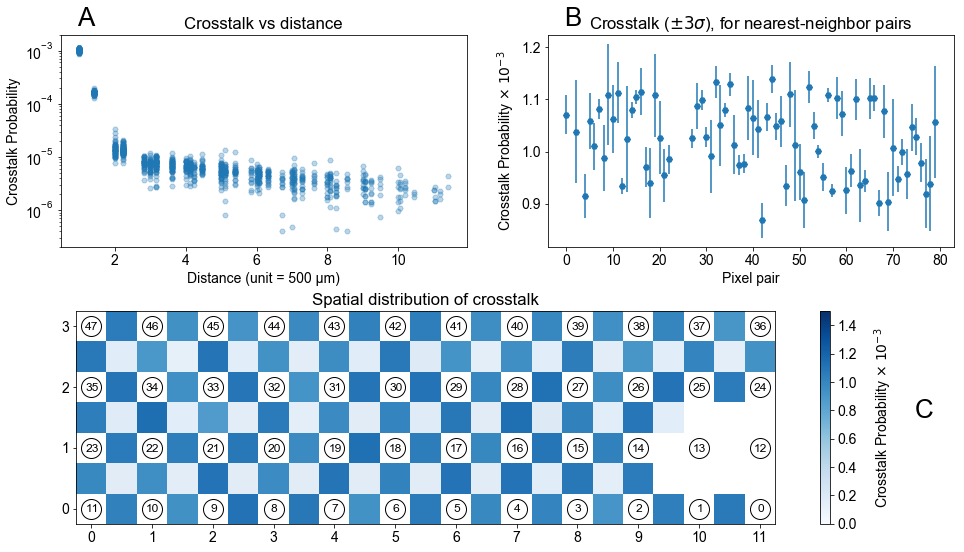

In [60]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(16, 9))
gs = gridspec.GridSpec(2, 2,
                       width_ratios=[1, 1],
                       height_ratios=[1,1]
                       )
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[1, :])
gs.update(hspace=0.3)

pairdata.plot(x='distance', y='crosstalk', kind='scatter', alpha=0.3, marker='H', s=30, 
               logy=True, ylim=(2e-7, 2e-3), ax=ax1);
ax1.set_ylabel(r'Crosstalk Probability')
ax1.set_xlabel(u'Distance (unit = 500 μm)')
ax1.set_title('Crosstalk vs distance')
ax1.text(0.04, 1.04, 'A', fontsize=26, transform=ax1.transAxes)

dist = 1
mask = pairdata['distance'] == dist
ax2.errorbar(x=np.arange(mask.sum()), y=pairdata['crosstalk'][mask]*1e3, yerr=3*pairdata['error'][mask]*1e3, fmt='H')
ax2.set_title('Crosstalk ($\pm 3\sigma$), for nearest-neighbor pairs');
ax2.set_ylabel(r'Crosstalk Probability $\times \; 10^{-3}$')
ax2.set_xlabel('Pixel pair')
ax2.text(0.04, 1.04, 'B', fontsize=26, transform=ax2.transAxes)

xs = np.arange(12)
ys = np.repeat(np.arange(4)[np.newaxis,:].T, xs.size, axis=1)
ax3.plot(xs, ys.T, 'o', ms=20, mew=1, mec='k', color='white')
im = ax3.imshow(a*1e3, interpolation='none', cmap='Blues', vmin=0, vmax=1.5,
                extent=(-0.25, 11.25, -0.25, 3.25))
for row in range(4):
    for col in range(12):
        ax3.text(col+0.01, row-0.01, str(m[row,col]), va='center', ha='center', fontsize=12)
im.cmap.set_under(alpha=0)
plt.colorbar(im)
ax3.set_xticks(range(12))
ax3.set_yticks(range(4));
ax3.set_title('Spatial distribution of crosstalk')
ax3.text(1.2, 0.5, 'C', fontsize=26, transform=ax3.transAxes)
ax3.text(1.14, 0.5, r'Crosstalk Probability $\times \; 10^{-3}$', rotation=90, va='center', transform=ax3.transAxes)
savefig(f'{mlabel}_crosstalk_{det}')